- PGGANの論文：[201710]Progessive Growing of GANs for Improved Quality, Stability, and Variation
- Tero Karras達, Nvidia
- https://arxiv.org/abs/1710.10196

### implement the PGGAN using TFHubの理由
- The original implementation of PGGAN took the NVIDIA researchers **one to two months to run**, which we thought was impractical for any person to run on their own, especially if you want to experiment or get something wrong.
- PGGANの実現コードが膨大で、TFHub allows us to skip over the boilerplate code and focus on the ideas that matter.

# 6.1 Latent space interpolation
- the initial trained latent space has **semantically meaningful** properties.
- 応用例：We can pick two random vectors and then move in equal increments between them and so gradually - smoothly - get an image that matches the second vector.
- Not only is the generative process predictable, but also the output is **not jagged - or reacting sharply to small changes** - considering the latent vector changes.

## 6.2.1 Progressive growing and smoothing of higher-resolution layers
- progressive growing.
 - 低解像度（小さい層）からどんどん**zoom in** (increase the complexity).
     - zoom inの実現は、adding extra layers.
     - increases in complexity only as we gain confidence that we are at the approximately right part of the loss space.

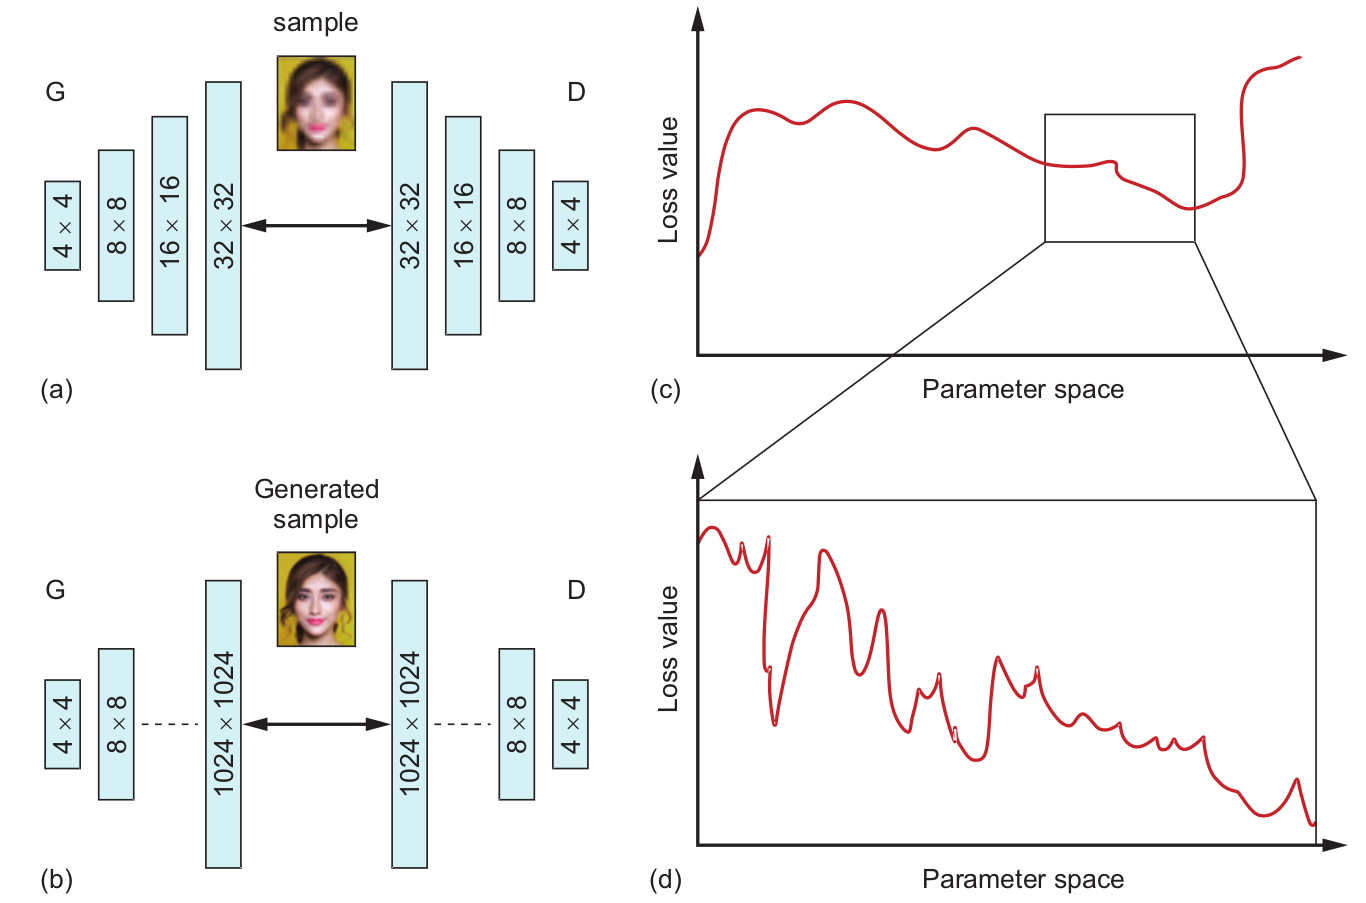

In [10]:
from IPython.display import Image
Image("img/pggan-progressive-growing-2020-02-23 21-42-23.png", width=900) 

- smoothly fade in.
 - fade inするのは低解像度の層。なぜなら、高解像度層をintroduceしたらメインは高解像度層をトレーニングするのだ。
 - なぜsmoothly fade in?
     - upon introducing even one more layer at a time, we are still introducing a massive shock to the training.
     - だからPGGANの発明者はsmoothly fade in trained lower resolution layers, in order to give the system **time to adapt to the higher resolution**.
 - やり方：高解像度層を導入後、一気に高解像度層通路に入れ替えるではなく、**２つ通路**の状態でトレーニングする。
     - 通路１：高解像度通路、重みは$\alpha$。
     - 通路２：学習済み低解像度通路（upscaleだけ）、重みは$1-\alpha$。パラメータなし。
         - simple nearest neighbor upscaling, which does not have any trained parameters.
     - 下記図(a)(b)(c)状態で全部自信が出るまでトレーニングする。

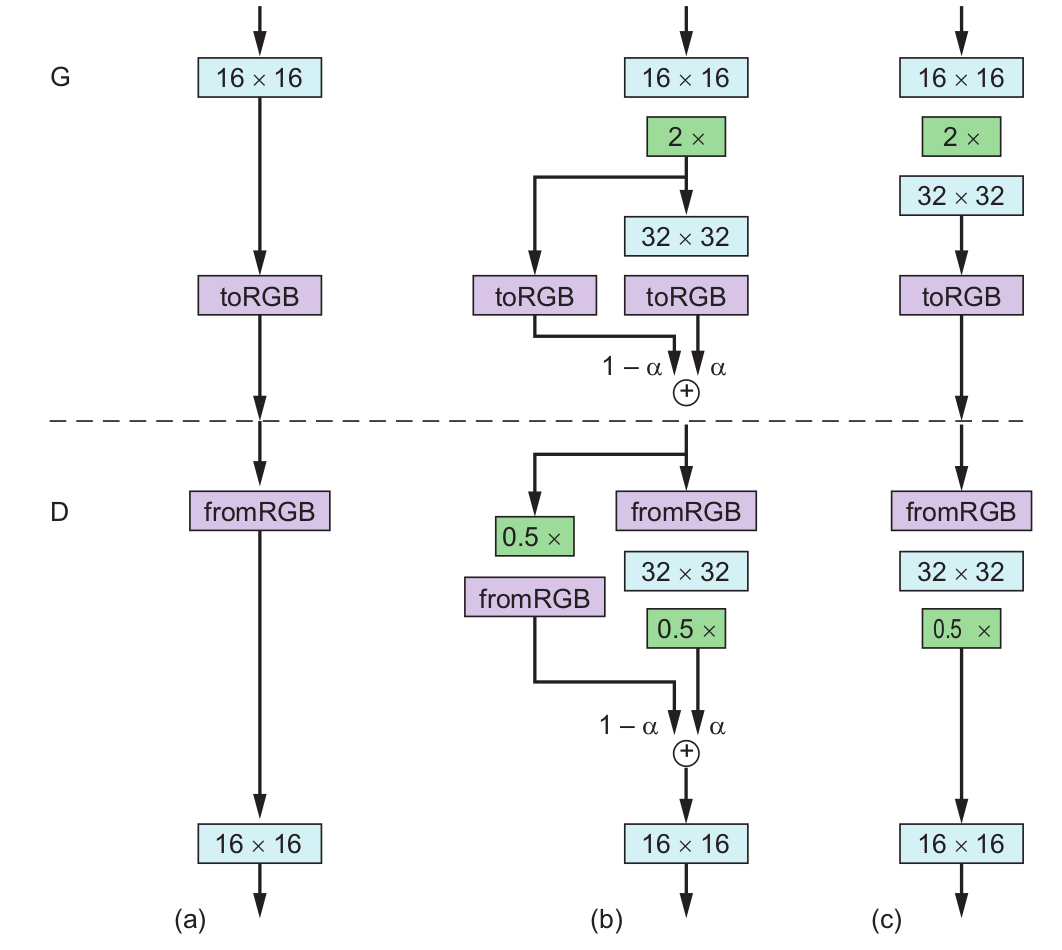

In [6]:
Image("img/pggan-smoothly-fade-in-2020-02-23 21-56-19.png", width=700)

## 6.2.3 Mini-batch standard deviation
- 課題対象：mode collapse.
 - 意味：the generator collapses which produces **limited varieties of samples**.例えばgeneratorが生成した数字の中に8が全然ない。
- 対策：Discriminatorにmini-batch standard deviationに構成された１つfeature mapを追加。
- Mini-batch standard deviationの計算や使用方法：
 - scalarの計算。例えばDiscriminatorの入力tensorが[B,W,H,C]のサイズ。
 - まずはB軸（axis=0, batch_size）に対してstandard deviationを計算。つまりstddevのサイズは[W,H,C]です。
 - またwidth, height, channelsに対して、stddevの平均値(scalar)を計算する。
 - 最後はこのmean stddev scalarを使って、[B,W,H]サイズのtensorを作って、layerに１つfeature mapとして追加する。
- 小さいmini-batch standard deviationを罰する。
 - 小さいmini-batch standard deviationだったら、つまりgeneratorが生成した画像の多様性が足りない。
 - 多様性が足りないと、Discriminatorはこれらが偽物だろうと分かる。本当の画像たちだとvarianceが高いはず。
- 本のコードが間違っているところが多いそう。下記のページの実装は分かりやすい。https://machinelearningmastery.com/how-to-train-a-progressive-growing-gan-in-keras-for-synthesizing-faces/
 - また、このページを見ると、MinibatchStddev層は入力画像が1つ目Conv2D, LeakyReLUのあとで1回のみ適用されている。

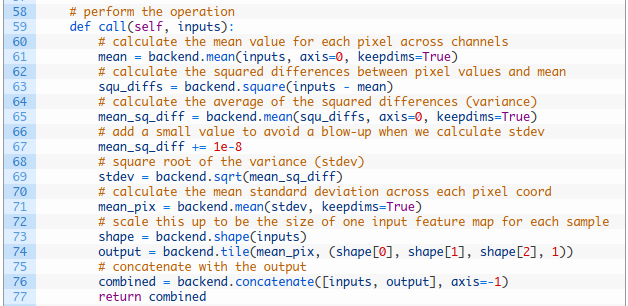

In [7]:
Image("img/pggan-minibatch-stddev-2020-02-24 00-38-04.png", width=600)

## 6.2.5 Pixel-wise feature normalization in the generator
- 超簡単。tensorのdepth軸で正規化する。
- なぜbatch normalizationを使わない？
 - batch normalizationはbatch_size軸で正規化するので、batch_sizeが大きい方が効果が出る。
 - しかし高解像度の場合、メモリの制限が厳しくなるので、batch_sizeは大きくなれない。
 - だから有効な小さいbatch_size場合の正規化が必要です。
 - その対策は、[BatchSize,Width,Height,Depth] tensorのDepth軸で正規化すること。
     - つまりpixelごとに正規化する。
     - $n_{x,y}=a_{x,y}/\sqrt{\frac{1}{N}\sum_{j=0}^{N-1}(a_{x,y}^j)^2+\epsilon}$.
     - $N$はthe number of feature maps.
- PixelNormalizationはGeneratorにのみ適用している。
 - The explosion in the activation magnitudes leads to an arms race **only if both** networks participate.

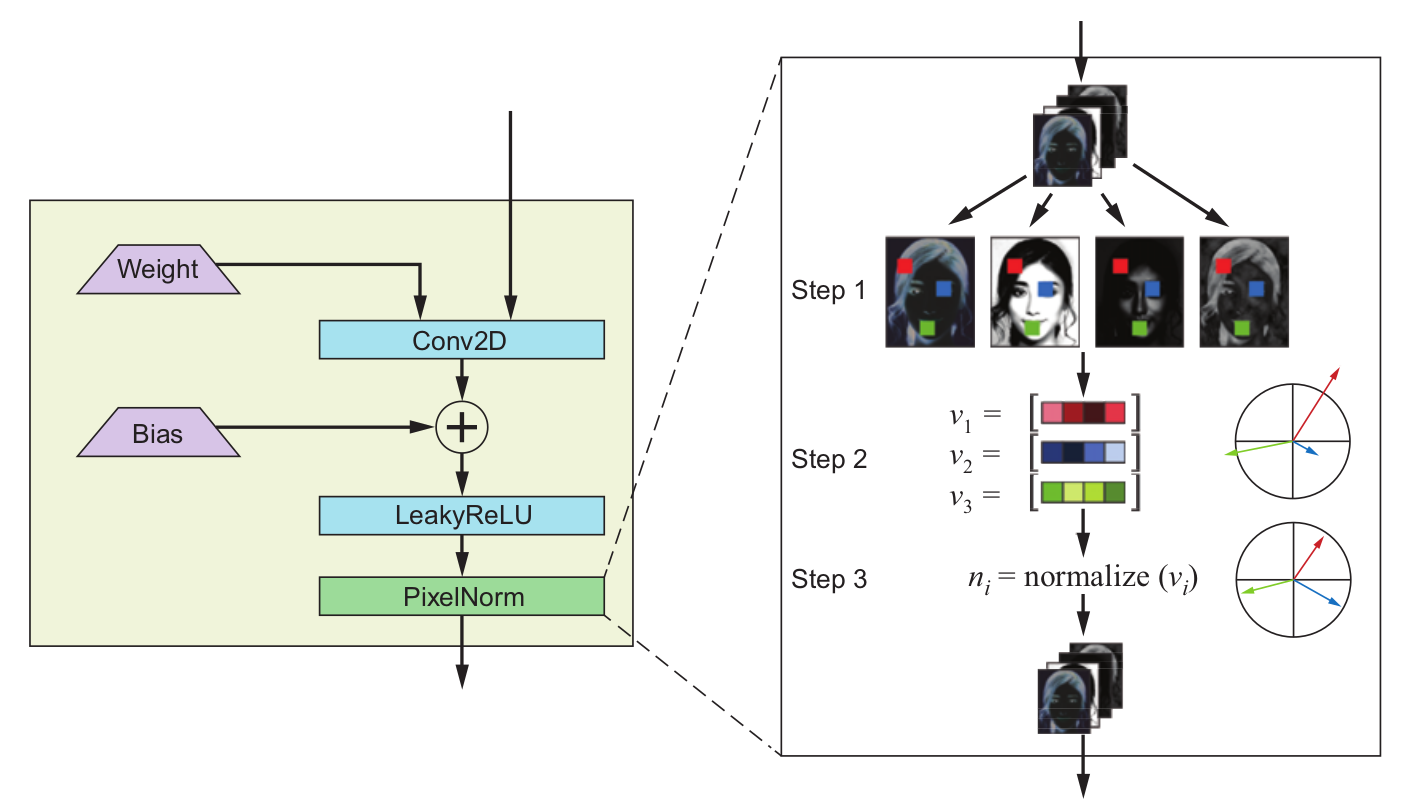

In [11]:
Image("img/pixel-wise-norm-2020-02-24 14-24-58.png", width=900)

In [2]:
import tensorflow as tf
import keras as K

## Point 1: Progressive Growing & Smoothing in of Higher Resolution Layers

In [ ]:
# 今回のコードはテストなしなので、間違っているところが多いようで、流れが分かったらOK。
def upscale_layer(layer, upscale_factor):
    # layerのサイズは[batch, height, width, channels]と期待している。
    height, width = layer.get_shape()[1:3]
    # upscale_factor倍でサイズを拡大する。
    size = (upscale_factor * height, upscale_factor * width)
    upscaled_layer = tf.image.resize_nearest_neighbor(layer, size)
    return upscale_layer

def smoothly_merge_last_layer(list_of_layers, alpha):
    # list_of_layers: tensors ordered by size。つまりlast layerは[-2]、最新層は[-1]。
    last_fully_trained_layer = list_of_layers[-2]
    # 学習済みの前の層を2倍拡大。
    last_layer_upscaled = upscale_layer(last_fully_trained_layer, 2)
    
    larger_native_layer = list_of_layers[-1]
    assert larger_native_layer.get_shape() == last_layer_upscaled.get_shape()
    
    new_layer = (1-alpha) * last_layer_upscaled + alpha * larger_native_layer
    
    return new_layer

## Point 4: Pixel-wise Feature Normalization

In [ ]:
# **kwargsは任意keyworded（key=value）入力。
def pixelwise_feat_norm(inputs, **kwargs):
    # axis=-1はchannels軸だ。もしinputsのサイズが[B,H,W,C]だったら、normalization_constantのサイズは[B,H,W,1]になる。
    normalization_constant = K.backend.sqrt(K.backend.mean(
        inputs**2, axis=-1, keepdims=True) + 1.0e-8)
    return inputs / normalization_constant

# Step 1: Running PGGAN from tensorflow Hub
## tensorflow Hubのインストール
- https://www.tensorflow.org/hub/installation
- TensorFlow 2が進めされている。まずtensorflow2にアップグレードしましょう。現在のtensorflowバージョンは1.14。

In [3]:
import tensorflow_hub as hub

ModuleNotFoundError: No module named 'tensorflow_hub'